In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import seaborn as sns

In [3]:
def winsorize(series,axis=0):
    '''The function uses robust statistics to winsorize a series
    '''
    if isinstance(series,pd.core.series.Series) or isinstance(series,np.ndarray) :
        median = np.nanmedian(series)
        robust_std = 1.4826*np.nanmedian((np.abs((series-median))))
        upper = median + 4*robust_std
        lower = median - 4*robust_std
        series[series>upper] = upper
        series[series<lower] = lower
        return series
    if isinstance(series,pd.core.frame.DataFrame):
        arr = series.values
        arr = np.apply_along_axis(winsorize,axis,arr)
        return pd.DataFrame(arr,index=series.index,columns=series.columns)

# Methodology : Classic Momentum

1. Resample time series to have monthly return series
2. For each month calculate trailing 12 months ( one year return)
3. Rank each stock cross sectionally for each month based on its yearly return rank
4. hold position for one month

This is a sample guide to a factor portfolio.

In [4]:
os.chdir(r"D:\\NSE DATA ROOM\\Research-Stuff\\")

files = glob("*.csv")
files = list(set(files))
files.remove('CloseAll.csv')
files.remove('UniverseData.csv')

file_list = []
for fle in files:#['HDFCBANK.csv','SBIN.csv']:
    df_temp = pd.read_csv(fle,index_col=[0],parse_dates=True)[['Close']]
    df_temp = df_temp.drop_duplicates()
    df_temp = df_temp.rename(columns={"Close":"{}".format(fle.strip(".csv"))})
    file_list.append(df_temp)

In [5]:
data = pd.concat(file_list,1)
daily_returns = data.pct_change()
daily_returns = winsorize(daily_returns,axis=1)
monthly_returns = daily_returns.resample('M').apply(lambda x:(1+x).prod()-1)
yearly_returns = monthly_returns.rolling(12,min_periods=6).apply(lambda x:(1+x).prod()-1)
yearly_rank = yearly_returns.rank(axis=1)
yearly_rank = yearly_rank.shift()

C:\Users\91882\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
C:\Users\91882\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
C:\Users\91882\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
C:\Users\91882\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """


In [6]:
mthly_rank = monthly_returns.copy()
for rank in range(1,yearly_returns.shape[1]+1):
    mthly_rank[rank] = monthly_returns[yearly_rank==rank].sum(1)
mthly_rank = mthly_rank[list(range(1,yearly_returns.shape[1]+1))]

In [7]:
mthly_port = mthly_rank.copy()

In [8]:
for alist in list(range(0,100,15)):
    mthly_port[f"P{int(alist/15)}"] = mthly_port.filter(list(np.arange(alist,alist+15))).mean(1)

In [9]:
mthly_port = mthly_port.filter(like='P')#.mean().plot.bar()

[Text(0, 0.5, 'Cumulative Returns')]

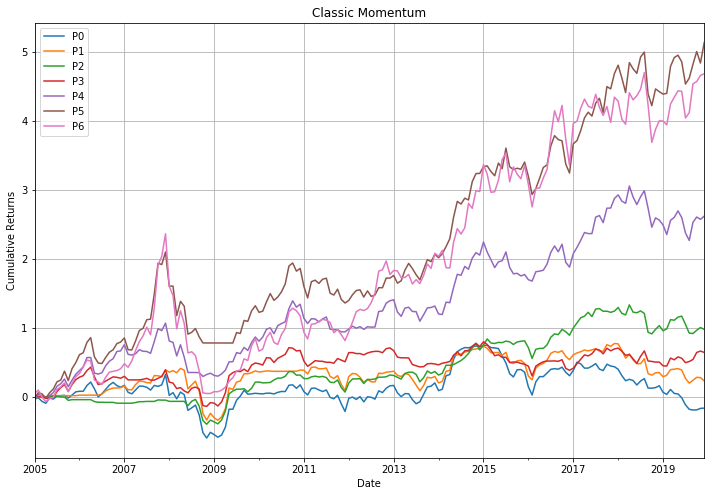

In [15]:
mthly_port_ = mthly_port.loc["2005-1-1":]
((mthly_port_+1).cumprod()-1).plot(figsize=(12,8),grid=True,
                                  title='Classic Momentum').set(ylabel='Cumulative Returns')

[Text(0.5, 1.0, 'Sharpe ratio for factor portfolio')]

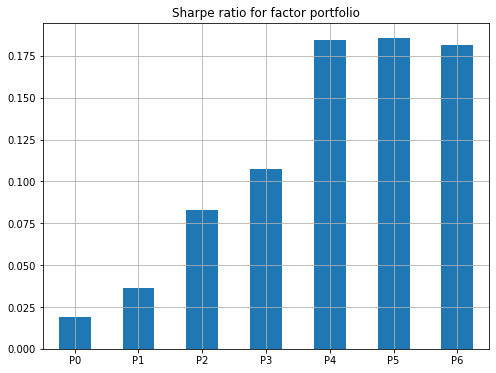

In [19]:
(mthly_port.mean()/mthly_port.std()).plot(kind='bar',rot=0,grid=True,figsize=(8,6)).set(title='Sharpe ratio for factor portfolio')

[Text(0.5, 1.0, 'Volatility of each factor portfolio')]

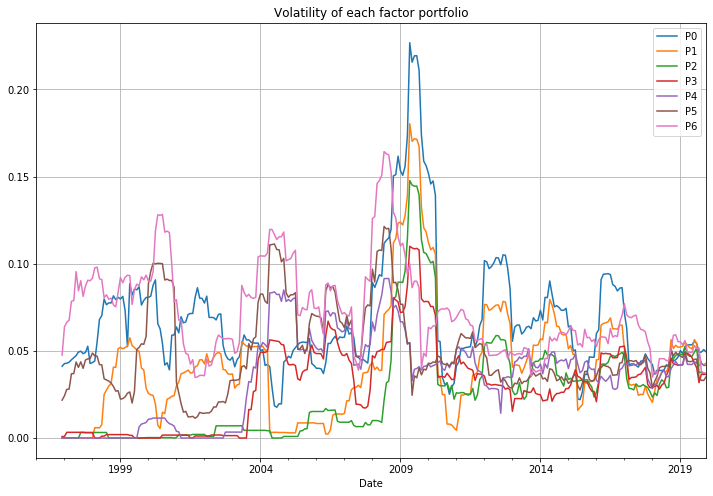

In [22]:
mthly_port.rolling(12).std().plot(figsize=(12,8),grid=True).set(title='Volatility of each factor portfolio')